<a href="https://www.kaggle.com/code/brunorateiro/titanic-eda-and-gbm-prediction?scriptVersionId=121374932" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

This is my take on the infamous [Titanic competition](https://www.kaggle.com/competitions/titanic).
We are given two datasets `train` and `test` containing passenger information. The goal is to achieve maximum **accuracy** while predicting if the passengers listed in `test` survived or not. Thus we have a classification problem.

Any feedback and ideas would be greatly appreciated, I would love to learn from and contribute to this amazing community!

<div style="width:100%;text-align: center;"> <img align=middle src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Titanic_Structure.jpg" alt="Heat beating" style="height:400px;margin-top:1rem;margin-bottom:1rem;"> </div>

<a id="ToC"></a>
## Table of contents
* [1. Data preparation](#1)  
  * [1.1 Libraries and settings](#1.1)
  * [1.2 Data reading](#1.2)
  * [1.3 Data cleaning](#1.3)
      * [1.3.1 Age](#1.3.1)
      * [1.3.2 Cabin](#1.3.2)
      * [1.3.3 Embarked](#1.3.3)
      * [1.3.4 Fare](#1.3.4)
* [2. Exploratory data analysis (EDA)](#2)
  * [2.1 Univariate analysis](#2.1)
  * [2.2 Multivariate analysis](#2.2)
      * [2.2.1 Correlation matrix](#2.2.1)
      * [2.2.2 Categorical versus continuous features](#2.2.2)
      * [2.2.3 Age versus discrete features](#2.2.3)
      * [2.2.4 Number of siblings or spouses versus number of parents or children](#2.2.4)
* [3. Machine learning](#3)
    * [3.1 Pipeline](#3.1)
    * [3.2 Baseline model](#3.2)
    * [3.3 Learning rate and number of estimators](#3.3)
    * [3.4 Tree-specific parameters](#3.4)
        * [3.4.1 Maximum depth and minimum samples](#3.4.1)
        * [3.4.2 Minimum samples to be a leaf](#3.4.2)
        * [3.4.3 Maximum number of features](#3.4.3)
    * [3.5 Subsample](#3.5)
    * [3.6 Revisiting learning rate and number of estimators](#3.6)
    * [3.7 Predictions](#3.7)
* [4. Conclusion](#4)

# 1. Data preparation <a id="1"></a>
[ToC](#ToC) | [Next](#1.1)

In this section relevant libraries and settings used are listed, different datasets are read and missing data is handled according to a preliminary analysis.

## 1.1 Libraries and settings <a id="1.1"></a> 
[Previous](#1) | [ToC](#ToC) | [Next](#1.2)

All imports and settings used throughout the study are listed in the hidden cell below.

In [1]:
# Dataset paths
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import ceil

# Data visualization
!pip install dython --quiet --root-user-action=ignore
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

custom_params = {
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "patch.force_edgecolor": True,
}
sns.set_theme(
    context = "notebook",
    style = 'ticks',
    palette = 'viridis',
    font_scale = 1.25,
    rc = custom_params,
)

# Pipelines
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

# Machine learning classifier and evaluation metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## 1.2 Data reading <a id="1.2"></a> 
[Previous](#1.1) | [ToC](#ToC) | [Next](#1.3)

The datasets considered in this study are:
* `train` (from *train.csv*): training set, containing information from passengers that we know they survived;
* `test` (from *test.csv*): test set, containing information from passengers we want to predict if they survived or not.

Another dataset `gender_submission` is only included to exemplify our output format.

The datasets are loaded into their respective dataframes, using their unique `PassengerId` as index.

The `train` dataframe has 891 entries and 12 columns. Some of the columns (`Age`, `Cabin` and `Embarked`) have missing values that will need to be handled. The `test` dataframe contains 418 entries. As expected,`test` has the same columns as `train` except `Survived`. There are missing values in columns `Age`, `Fare` and `Cabin`.

The competition documentation have data dictionaries for the columns `Survived`, `Pclass` and `Embarked`. Mapping corresponding dictionary values using suffix `_x` to column name adds three columns to the `train` dataframe that will later be used to better label our data during EDA.

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
train.name = 'train'

test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')
test.name = 'test'

gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv', index_col='PassengerId')
gender_submission.name = 'gender submission'

both = [train, test] # Useful when needing to call or transform both datasets

def dataframe_summary():
    "Prints a summary for both datasets"
    for df in both:
        print(f"'{df.name}' dataframe summary:")
        print(f"Is '{df.name}' dataframe index unique? {df.index.is_unique}")
        df.info(memory_usage=False)
        print('\n')
dataframe_summary()
    
# Data dictionaries, useful when visualizing data
data_dictionaries = {
    'Survived': {0:'Perished', 1:'Survived'},
    'Pclass': {1:'1st', 2:'2nd', 3:'3rd'},
    'Embarked': {'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'}
}

# Apply data dictionary to 'train' to facilitate understanding
for column, dictionary in data_dictionaries.items():
    train[column+'_x'] = train.loc[~train[column].isnull(), column].apply(lambda x: dictionary[x])
    
print("'train' dataframe:")
train.head()

'train' dataframe summary:
Is 'train' dataframe index unique? True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)

'test' dataframe summary:
Is 'test' dataframe index unique? True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null  

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_x,Pclass_x,Embarked_x
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Perished,3rd,Southampton
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived,1st,Cherbourg
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived,3rd,Southampton
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived,1st,Southampton
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Perished,3rd,Southampton


## 1.3 Data cleaning <a id="1.3"></a>
[Previous](#1.2) | [ToC](#ToC) | [Next](#1.3.1)

We have four columns that have missing values in either dataframe. For each column we will make a preliminary exploration and decide how we will handle these values in both dataframes. We will use solely information from `train` dataframe to avoid data leakage.

The hidden cell below contains some helper functions that will help us summarize data, replace missing values and plot histograms and boxplots during data cleaning stage.

In [3]:
def summarize(column_name: str) -> None:
    """
    Given a column name, print column null count for both dataframes.
    Then give a statistical summary for this column on train dataframe
    """
    for df in both:
        print(
            f"There are {df[column_name].isnull().sum()}/{df.shape[0]} " 
            f"null values in column '{column_name}' of '{df.name}' dataframe."
        )
    print(f"\nStatistical summary for '{column_name}' series in 'train' dataframe:")
    print(train[column_name].describe(), '\n')
    
def histogram_and_boxplot(column_name: str, ceiling=float('inf')) -> None:
    """
    Given a column name, return a grid showing a histogram for total count distribution
    and a boxplot highlighting median and outliers for passengers divided by survival.
    
    If a custom ceiling value is given, our plots will consider the fraction of the data
    up to ceiling value.
    """
    # Set figure grid
    fig, axes = plt.subplots(
        nrows = 2,
        ncols = 1, 
        sharex = True, 
        figsize = (10,6),
        gridspec_kw = dict(height_ratios=[2,1])
    )
    # Set suptitle to right align and position it in the top right corner
    title = f"{column_name} distribution in training data"
    title += f' (<= {ceiling})' if ceiling != float('inf') else ''
    fig.suptitle(
        title,
        ha = 'right',
        x = 0.95,
        y = 1,
    )
    if ceiling != float('inf'):
        plt.setp(axes, xlim =(0, ceiling))
        
    # Use tight layout to plot more cleanly
    fig.tight_layout()
    fig.subplots_adjust(top=1)
    
    # Get non NA points for column_name
    train_dropna = train[train[column_name].notnull()]
    
    # Select custom pallete, width and color for lines
    palette = dict(Perished='lightcoral', Survived='lightgreen')
    edgecolor = 'k'
    linewidth = 1
    
    # Boxplot
    boxes = sns.boxplot(
        data = train_dropna,
        x = column_name,
        y = 'Survived_x',
        hue = 'Survived_x',
        ax = axes[1],
        saturation = 1,
        palette = palette,
        linewidth = linewidth,
        dodge = False,
        boxprops = dict(edgecolor=edgecolor),
        medianprops = dict(color=edgecolor),
        whiskerprops = dict(color=edgecolor),
        flierprops = dict(markerfacecolor=edgecolor),
        capprops = dict(color=edgecolor),
    )
    # Boxpot style options
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].spines[['left', 'bottom']].set_visible(False)
    axes[1].legend([],[],frameon=False) # Remove legend
    
    # Annotate median value according to survivability
    medians = train_dropna.groupby('Survived_x')[column_name].median()
    for i in range(len(medians)):
        boxes.annotate(
            f' {medians[i]:.1f}',
            xy = (medians[i], i),
            ha = 'left',
            va = 'center',
        )    
    # Get legend information to be transported to histogram and format its line
    handles, labels = axes[1].get_legend_handles_labels()
    for handle in handles:
        handle.set_edgecolor(edgecolor)
        handle.set_linewidth(1)
    
    # Histogram plot
    sns.histplot(
        data = train_dropna,
        x = column_name,
        hue = 'Survived_x',
        multiple = 'stack',
        stat = 'count',
        ax = axes[0],
        edgecolor = edgecolor,
        alpha = 1,
        palette = palette,
    )
    axes[0].get_yaxis().set_visible(False)
    axes[0].spines[['left']].set_visible(False)
    axes[0].tick_params(labelbottom=True)
    
    # Annotate median on histogram
    median = train_dropna[column_name].median()
    axes[0].axvline(
        x = median,
        c = edgecolor,
        label = 'Median',
        ls = 'dashed',
        lw = 1.25,
        ymax = 0.95,
    )
    axes[0].text(
        x = median,
        y = 0.95,
        s = f' {median:.1f}',
        ha = 'left',
        va = 'top',
        transform=axes[0].get_xaxis_transform(),
    )
    # Get median line information and updata label
    h, l = axes[0].get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
    axes[0].legend(
        handles, labels,
        bbox_to_anchor = (1, 0.9), 
        frameon = False,
        edgecolor = edgecolor,
    )
    fig.show()
    
def replace_na_by_median(column_name:str) -> None:
    "Replaces missing values in given column using 'train' median."
    for df in both:
        df.loc[df[column_name].isnull(), [column_name]] = train[column_name].median()

### 1.3.1 Age <a id="1.3.1"></a>
[Previous](#1.3) | [ToC](#ToC) | [Next](#1.3.2)

In order to study `Age` distribution we consider its summary statistics and two plots. The first plot is a stacked histogram and the second is a boxplot. It might be interesting to evaluate how `Age` is distributed if we were to divided the entries into groups of those who survived and those who perished.

The `Age` stacked histogram shows a roughly bimodal normal distribution slightly right-skewed.
The boxplot evidentiate that the median age remains 28 regardless of the survivability group. It also highlights the outliers are concentrated among the oldest passengers for each group.

In order to preserve the distribution shape, we can use the `train` median as a fill value for missing `Age` values. We are using the median and not the mean because the median is a more reliable center measure when the distribution is skewed.

There are 177/891 null values in column 'Age' of 'train' dataframe.
There are 86/418 null values in column 'Age' of 'test' dataframe.

Statistical summary for 'Age' series in 'train' dataframe:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 



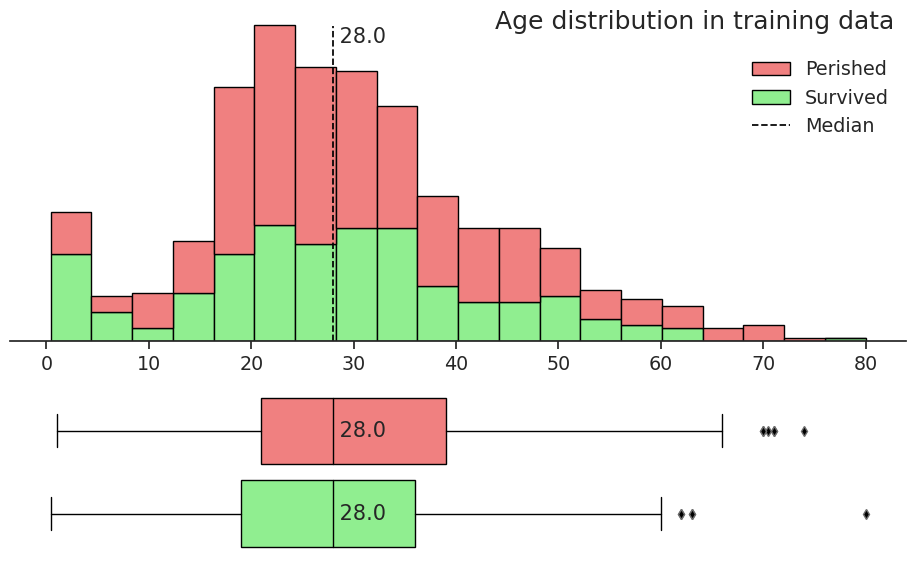

In [4]:
summarize('Age')
histogram_and_boxplot('Age')
replace_na_by_median('Age')

### 1.3.2 Cabin <a id="1.3.2"></a>
[Previous](#1.3.1) | [ToC](#ToC) | [Next](#1.3.3)

The majority of values in `Cabin` column is missing in both dataframes. Two observations can be made:
1. If we grouped missing values in a category (say `missing`), this category would represent the majority of cases. 
2. Looking at the frequency of unique non-missing values we see they are too numerous and each have a very small frequency. The most frequent unique values have a frequency of 4.

An approach could be consider missing values as a category and transform `Cabin` into frequency categories (frequent/infrequent). But observations 1 and 2 combined would result in a very biased and noninformative feature.

Another approach would be to create a binary feature that checks if a passenger was assigned a cabin or not.

Initially, we opt not to include `Cabin` information in our study.

In [5]:
summarize('Cabin')
for df in both:
    df.drop('Cabin', axis='columns', inplace=True)

There are 687/891 null values in column 'Cabin' of 'train' dataframe.
There are 327/418 null values in column 'Cabin' of 'test' dataframe.

Statistical summary for 'Cabin' series in 'train' dataframe:
count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object 



### 1.3.3 Embarked <a id="1.3.3"></a>
[Previous](#1.3.2) | [ToC](#ToC) | [Next](#1.3.4)

There are only 2 missing values in `train` dataframe. As this is a very small portion of data, we choose to ignore these two entries moving forward.

In [6]:
summarize('Embarked')
train.dropna(subset=['Embarked'], inplace=True)

There are 2/891 null values in column 'Embarked' of 'train' dataframe.
There are 0/418 null values in column 'Embarked' of 'test' dataframe.

Statistical summary for 'Embarked' series in 'train' dataframe:
count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object 



### 1.3.4 Fare <a id="1.3.4"></a>
[Previous](#1.3.3) | [ToC](#ToC) | [Next](#2)

There's a single missing `Fare` value in `test` dataframe. We will treat the missing `Fare` value in `test` as we did the missing `Age` values, replacing missing values with the median of all passengers.

We have outliers going up to 512, but according to our summary, the distribution median is 14.45. The partial `Fare` stacked histogram shows a unimodal distribution heavily right-skewed. We will try and attenuate the effect of ouliers on machine learning by capping all fares superior to the 90% quantile in training data, which in this case was 78.5.

The boxplot evidentiate that the distribution of passengers who perished compared to those who survived have a smaller median and a more concentrated IQR.

There are 0/889 null values in column 'Fare' of 'train' dataframe.
There are 1/418 null values in column 'Fare' of 'test' dataframe.

Statistical summary for 'Fare' series in 'train' dataframe:
count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64 



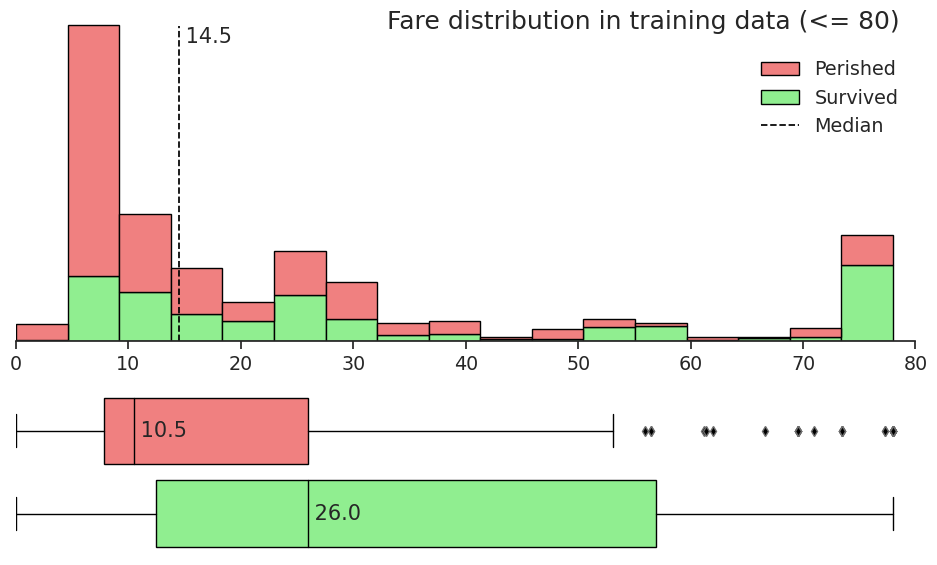

In [7]:
summarize('Fare')

# Trim outliers at 90% quantile
ceiling = ceil(train.Fare.quantile(0.9))
for df in both:
    df.loc[df.Fare >= ceiling, 'Fare'] = ceiling

histogram_and_boxplot('Fare', (ceiling//10+1)*10)
replace_na_by_median('Fare')

# 2. Exploratory data analysis (EDA) <a id="2"></a>
[Previous](#1.3.4) | [ToC](#ToC) | [Next](#2.1)

From `train` dataset we make a primary selection of 7 features besides our prediction target `Survived`. In order to make EDA as readable as possible we are going to use the translated features with suffix `_x`. For modeling purposes we will use their original values.

In the following sections we are going to make univariate and multivariate analysis. We are going to discuss any detection of associated features.

In [8]:
primary_features = ['Sex', 'Age', 'Embarked', 'SibSp', 'Parch', 'Fare', 'Pclass']
primary_target = ['Survived']

categorical = ['Sex', 'Embarked','Pclass']
continuous = ['Age', 'Fare']
discrete = ['SibSp', 'Parch']

# Stratify both Age and Fare in order to analyse them
train['Age_x'] = pd.cut(
    train.Age, 
    list(range(0,90,10)),
    labels = [f'{i}0-{i+1}0' for i in range(8)],
)
train['Fare_x'] = pd.qcut(
    train.Fare, 
    q = 4, 
    labels = ['Q1', 'Q2', 'Q3', 'Q4'],
)

train[primary_target + primary_features].head()

,Survived,Sex,Age,Embarked,SibSp,Parch,Fare,Pclass
PassengerId,,,,,,,,
1,0,male,22.0,S,1,0,7.2500,3
2,1,female,38.0,C,1,0,71.2833,1
3,1,female,26.0,S,0,0,7.9250,3
4,1,female,35.0,S,1,0,53.1000,1
5,0,male,35.0,S,0,0,8.0500,3


The following hidden cell contains a dictionary that controls plot settings.

In [9]:
# Feature: (Title, Use translated column, Prefered order, Y-axis limit)
settings = {
    'Sex': ('Sex', False, ['female', 'male'], None),
    'Age': ('Age', True, None, None),
    'Pclass': ('Passenger class (Pclass)', True, ['3rd', '2nd', '1st'], None),
    'SibSp': ('Number of siblings or spouses (SibSp)', False, None, None),
    'Parch': ('Number of parents or children (Parch)', False, None, None),
    'Fare': ('Fare', True, None, (ceiling//10+1)*10), 
    'Embarked': ('Port of embarkation (Embarked)', False, None, None),
    'Survived': ('Survived', False, None, None)
} 

## 2.1 Univariate analysis <a id="2.1"></a> 
[Previous](#2) | [ToC](#ToC) | [Next](#2.2)

We analyse the survivability ratio for each category in every feature by taking the mean `Survived` for that specific subset. Our initial selection of features contain categorical and numerical features. The numerical continuous features `Age` and `Fare` need to be stratified. The numerical discrete features such as `SibSp` assume a reasonably small number of different values and do not need to be stratified.

Some observations can be made:
* `Sex`: Female passengers have a substantialy higher (0.74) survivability rate than their male counterparts (0.19), suggesting a strong association with survival.
* `Age`: Stratifying passenger age into intervals of 10 years, we can observe that there is a general trend that implies that the older a passenger was, the less likely it was to survive.
* `Embarked` (Port of embarkation): Passengers that embarked from the Cherbourg port had a substantialy higher survivability ratio (0.55) than passengers that embarked from Southampton (0.34) or Queenstown (0.39) ports.
* `SibSp` (Number of siblings or spouses): general trend indicating that the higher `SibSp`, the less likely was a passenger to survive. Exception made for having no `SibSp`.
* `Parch` (Number of parents or children): passengers with `Parch` from 1 to 3 have a substantialy higher survivability ratio than passengers with 0 `Parch` (0.34). From `Parch` 4 onwards, the ratio drops to levels worse than `Parch` 0.
* `Fare`: Stratifying into quantiles where Q1 represents passengers that paid the lowest fare and Q4 the highest, we observe a general trend that the higher the fare, the more likely a passenger was to survive.
* `Pclass`: lower class passengers were more unlikely to survive than higher class passengers.

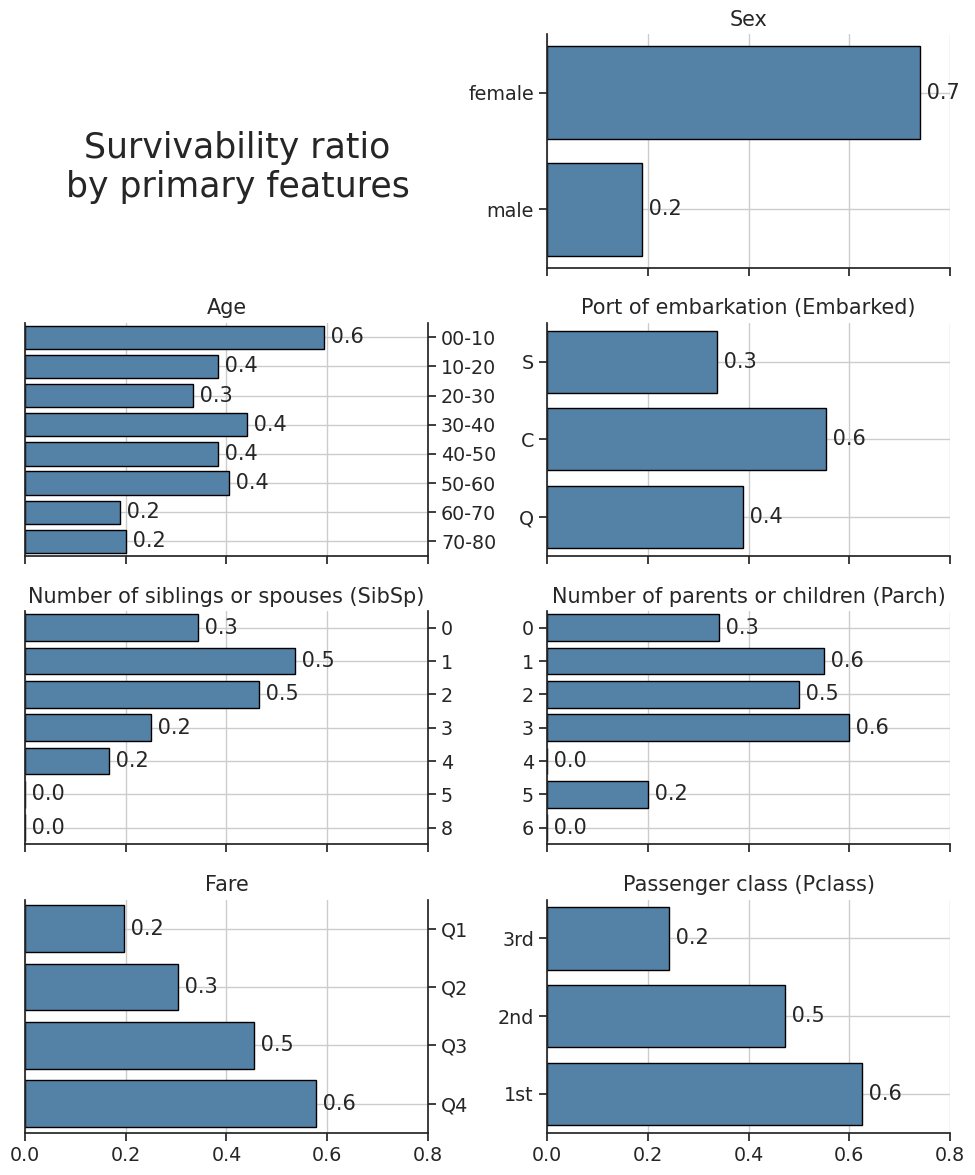

In [10]:
def barplot(column_name: str, ax, right_side) -> None:
    'Returns survivability rate barplots for different features'
    
    # Choose if we are going to use the translated column
    y = column_name
    if settings[column_name][1]:
        y += '_x'
    
    sns.barplot(
        ax = ax,
        data = train,
        x = 'Survived',
        y = y,
        order = settings[column_name][2],
        color = 'steelblue',
        edgecolor = 'k',
        orient = 'h',
        errorbar = None,
    ).set(
        title = settings[column_name][0],
        xlabel = None,
        ylabel = None,
    )
    ax.bar_label(
        ax.containers[-1], 
        fmt=' %.1f', 
        label_type='edge'
    )
    
    if right_side: # Rotate y labels and axis for odd numbered axis
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.spines[['right']].set_visible(True)
    
    ax.grid()
    plt.tight_layout()

def univariate():
    'Returns survivability rate barplots for different features'   
    
    # Set figure grid
    fig, axes = plt.subplots(
        nrows = 4,
        ncols = 2, 
        sharex = True, 
        figsize = (10,12),
    )
    axes = axes.flatten() # Make axes array one dimensional
    axes[0].set_xlim([0, 0.8])
    fig.delaxes(axes[0]) # Make space for title

    # Title
    fig.text(
        x = 0.25, 
        y = 0.85,
        s = "Survivability ratio\nby primary features",
        ha="center", 
        va="center", 
        size=25,
    )

    # Fill grid with primary features univariate plots
    for i, feature in enumerate(primary_features):
        barplot(feature, axes[i+1], bool(i % 2))
        
univariate()

## 2.2 Multivariate analysis <a id="2.2"></a>
[Previous](#2.1) | [ToC](#ToC) | [Next](#2.2.1)

We generate a correlation matrix to help us identify the strongest associations between features. we generate visualizations for some of these associations to help and explore them further. 

### 2.2.1 Correlation matrix <a id="2.2.1"></a> 
[Previous](#2.2) | [ToC](#ToC) | [Next](#2.2.2)

The train data set contains heterogeneous data. We will create a correlation matrix by using the [associations function from dython library.](https://shakedzy.xyz/dython/modules/nominal/#associations) It uses different strategies to calculate feature association according to the feature types:
- Continuous-continuous cases: [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), 
- Categorical-continuous cases: [Correlation ratio](https://en.wikipedia.org/wiki/Correlation_ratio#:~:text=In%20statistics%2C%20the%20correlation%20ratio,representing%20these%20types%20of%20variation.), 
- Categorical-categorical cases: [Cramer’s V](https://www.statstest.com/cramers-v-2/).

It's important to note that we traverse `Pclass` in the following order: 1st, 2nd then 3rd, i.e. decreasing social class status.

Some observations can be made from the correlation matrix:
* Target `Survived`: As stated in univariate analysis, there is a strong association between survivability and `Sex`. It's also significant the association with features `Fare`,`Embarked` and `Pclass`, although the last is negative because of the feature order. Associations with the remainder features `Age`, `SibSp` and `Parch` are weak.
* The number of parents or children `Parch` and `Fare` seems to be associated with `Sex`.
* `Age` is inversely associated with number of siblings or spouses `SibSp`, `Parch` and `Pclass`. 
* Port of embarkation `Embarked` is associated with passenger class and fare.
* `SibSp` and `Parch`: these features are highly associated, possibly indicating that passengers either traveled alone or acompanied with many family members.
* `Pclass` and `Fare`: strongly associated, the better the social class, the higher the `Fare`

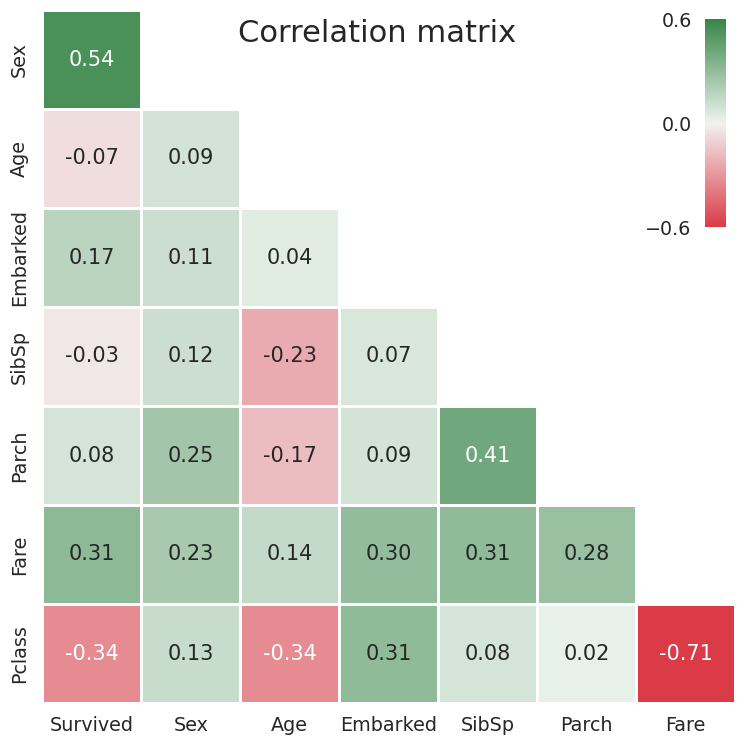

In [11]:
def correlation_matrix(features):
    "Prints correlation matrix for selected features, even categorical"
    corr = associations(
        dataset = train[features],
        plot = False,
        compute_only = True,
    )['corr'];

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(9, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 133, as_cmap=True)

    # Remove first row and column, they would be empty
    corr = corr.iloc[1:,:-1]
    mask = mask[1:,:-1]

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(
        data = corr, 
        mask = mask, 
        cmap = cmap,
        fmt = '.2f',
        cbar = False,
        vmax = .6,
        vmin = -.6,
        center = 0,
        annot = True,
        square = True,
        linewidths = 2,
        cbar_kws = {"shrink": .5}
    )
    ax.tick_params(left=False, bottom=False)

    # Title
    fig.text(
        x = .5, 
        y = .87,
        s = "Correlation matrix",
        ha="center", 
        va="top", 
        size=22,
    );

    # Custom colorbar axis
    cbaxes = inset_axes(
        ax,
        width="3%", 
        height="30%", 
        loc=1
    )

    # Populate colorbar
    clb = plt.colorbar(
        mappable = ax.collections[0],
        cax = cbaxes,
        ticks = [-.6,0,.6],
        orientation = 'vertical',
        drawedges = False,
    )

    # Remove outline, rotate tick labels and remove ticks
    clb.outline.set_visible(False)
    cbaxes.yaxis.tick_left()
    cbaxes.tick_params(left=False, bottom=False)

correlation_matrix(primary_target+primary_features)

### 2.2.2 Categorical versus continuous features <a id="2.2.2"></a> 
[Previous](#2.2.1) | [ToC](#ToC) | [Next](#2.2.3)

We can generate a violin plot to explore how categorical features `Sex`, `Embarked` and `Pclass` relate to continuous features `Age` and `Fare`. From the graph we can extract that:
* `Age` and `Sex`: distributions roughly the same, but the older passengers tended to be male.
* `Age` and `Embarked`: passengers that embarked at Southampton and Cherbourg ports had an evenly distributed survivability rate regardless of their age. Passengers that embarked at Queenstown and survived are concentrated around the age median.
* `Age` and `Pclass`: people that belonged to higher social classes tended to be slightly older.
* `Fare` and `Sex`: roughly the same survivability distribution regardless of sex.
* `Fare` and `Embarked`: passengers paid higher fares at Cherbourg port, followed by Southampton and lower fares at Queenstown. 
* `Fare` and `Pclass`: as previously shown by correlation matrix and intuitively, passengers belonging to a higher social class paid higher fares.

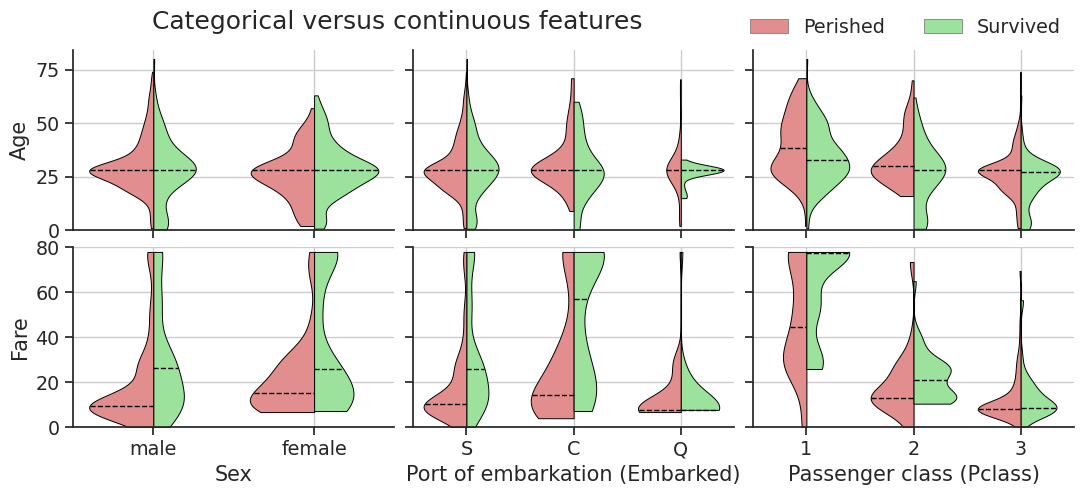

In [12]:
def categorical_vs_continuous_plot():
    "Plots a violin plot for each pair of categorical and continuous features."
    
    g = sns.PairGrid(
        data = train, 
        hue = 'Survived_x',
        hue_order = ['Perished', 'Survived'],
        x_vars = categorical,
        y_vars = continuous,
        palette = dict(Perished='lightcoral', Survived='lightgreen'),
        aspect = 1.5
    )
    g.map(
        sns.violinplot, 
        split = True, 
        edgecolor = 'k', 
        linewidth = 1,
        inner = 'quartiles',
        linestyle = ':',
        orient = 'v',
        cut = 0,
    )
    # Title and legend
    g.tight_layout()
    g.fig.suptitle(
        t = 'Categorical versus continuous features', 
        x = 0.13,
        ha = 'left',
    )
    g.fig.subplots_adjust(top=0.9)
    g.add_legend(
        title = '', 
        loc = 'upper left',
        ncol = 2,
        bbox_to_anchor=(.53, 1),
    );

    # Additional tweaks in matplotlib
    for ax in g.fig.axes:
        ax.grid() # Add grid to the plot
        
        # Get information from settings according to axis labels
        x_settings = settings[ax.get_xlabel()]
        y_settings = settings[ax.get_ylabel()]
        
        # Customize limits according to settings
        ax.set_ylim(bottom=0)
        if y_settings[3]:
            ax.set_ylim(top=y_settings[3])
        
        # Change labels
        ax.set_xlabel(x_settings[0])
        ax.set_ylabel(y_settings[0])
        
        # Change violinplot contour to make it more visible
        for container in ax.collections:
            container.set_edgecolor('k')
            container.set_linewidth(.7)
        
        # Keep only median lines
        for i, l in enumerate(ax.lines):
            if not (i%3-1): # Style median line
                l.set(linestyle = '--', color = 'k')
            else:
                l.set(visible = False) # Remove IQR
                
categorical_vs_continuous_plot()

### 2.2.3 Age versus discrete features <a id="2.2.3"></a> 
[Previous](#2.2.2) | [ToC](#ToC) | [Next](#2.2.4)

* The dispersion of `Age` distribution decreases as we increase the number of siblings or spouses `SibSp`. Meaning that we can expect that the more accompanied by siblings or spouses a passenger was, the younger this passenger was.
* The same can be said to the number of parents or children up to 3. The more accompanied by parents or children, the younger this passenger was.

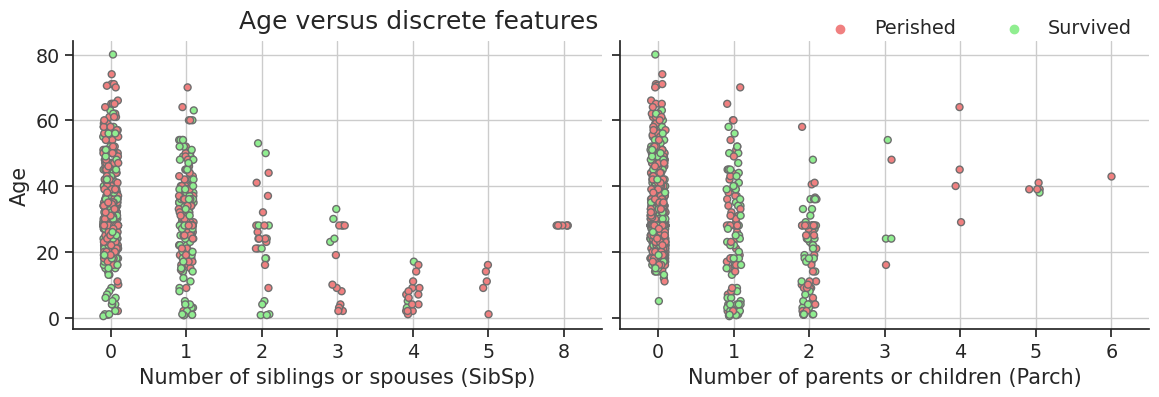

In [13]:
def continuous_vs_discrete(continuous, discrete):
    "Strip plots for each combination of continuous vs discrete features"
    
    g = sns.PairGrid(
        data = train, 
        hue = 'Survived_x',
        hue_order = ['Perished', 'Survived'],
        x_vars = discrete,
        y_vars = 'Age',
        palette = dict(Perished='lightcoral', Survived='lightgreen'),
        height = 4,
        aspect = 1.5,
    )
    g.map(
        sns.stripplot, 
        linewidth = 1,
        dodge = False,
    )
    # Title and legend
    g.tight_layout()
    g.fig.suptitle(
        t = 'Age versus discrete features', 
        x = 0.18,
        ha = 'left',
    )
    g.fig.subplots_adjust(top=0.9)
    g.add_legend(
        title = '', 
        loc = 'upper left',
        ncol = 2,
        bbox_to_anchor=(.55, 1),
    );

    # Additional tweaks in matplotlib
    for ax in g.fig.axes:
        ax.grid() # Add grid to the plot

        # Get information from settings according to axis labels
        x_settings = settings[ax.get_xlabel()]
        y_settings = settings[ax.get_ylabel()]

        # Change labels
        ax.set_xlabel(x_settings[0])
        ax.set_ylabel(y_settings[0])
        
continuous_vs_discrete('Age', discrete)

### 2.2.4 Number of siblings or spouses versus number of parents or children <a id="2.2.4"></a> 
[Previous](#2.2.3) | [ToC](#ToC) | [Next](#3)

For both `SibSp` and `Parch` we create an correspondent `_x` variant that aggregates infrequent data points. From the mosaic plot using these variables we observe that:
* The vast majority of passengers were not accompanied by close family members.
* If a passenger was accompanied by a family member belonging to either `SibSp` or `Parch` groups, the more likely it was that this passenger was accompanied by a family member belonging to the complementary group, as evidentiated by the decreasing height of blue rectangles reserved for passengers not accompanied by parents or children as the number of siblings or spouses increases.

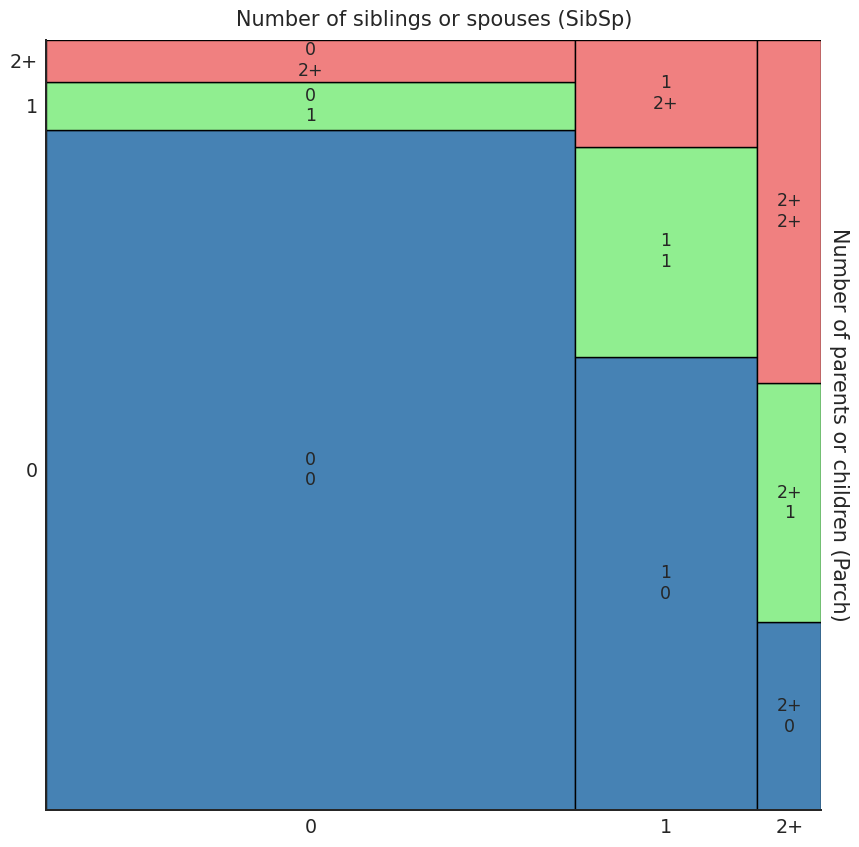

In [14]:
def mosaic_plot(feature_a, feature_b, threshold=2):
    "Create a mosaic plot for two discrete features and consider a threshold to aggregate infrequent data"
    
    def aggregate_infrequent(value):
        'Create aggregated feature from a numerical feature'
        
        if value >= threshold:
            return str(threshold) + '+'
        return str(value)

    # Aggregate features according to threshold
    for feature in [feature_a, feature_b]:
        train[feature + '_x'] = train[feature].apply(aggregate_infrequent)

    def rectangle_properties(rectangle):
        "Set colors according to y labels"
        
        if rectangle[1] == '0':
            color = 'steelblue'
        elif rectangle[1] == '1':
            color = 'lightgreen'
        else:
            color = 'lightcoral'
            
        return {
            'facecolor': color,
            'linewidth': 1,
            'edgecolor': 'k',
        }
    
    # Create mosaic plot
    fig, rects = mosaic(
        data = train.sort_values([feature_a, feature_b]),
        index = [feature_a+'_x', feature_b+'_x'],
        gap = 0,
        properties = rectangle_properties,
    )
    # Figure parameters 
    fig.set_size_inches(10, 10, forward=True)
    fig.axes[0].tick_params(
        left = False,
        bottom = False,
        pad = 0,
    )
    # Label text and position
    ax = fig.axes[0]    
    ax.set_xlabel(settings[feature_a][0], labelpad=10)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel(settings[feature_b][0], rotation=270, labelpad=20)
    ax.yaxis.set_label_position('right')
    
mosaic_plot('SibSp', 'Parch')

# 3. Machine learning <a id="3"></a>
[Previous](#2.2.4) | [ToC](#ToC) | [Next](#3.1)

Inspired by [Owen Zhang's 'Learn Kaggle techniques from Kaggle #1'](https://www.youtube.com/watch?v=LgLcfZjNF44), I would like to explore Gradient Boosting implementation on Scikit Learn and chose this as our method to approach this classification task. The procedure to tuning the model will follow this [excelent GBM guide by Aarshay Jain](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/). First, we will encode our features, create a pipeline that at the end contains our model and then try and analyse the output of many parameter tuning in order to improve our final result.

## 3.1 Pipeline <a id="3.1"></a> 
[Previous](#3) | [ToC](#ToC) | [Next](#3.2)

The features `Sex` and `Embarked` are categorical and need to be transformed using one-hot-encoder. A feature of _n_ categories is completely defined by _n-1_ columns after one-hot-encoding. One example using `Sex` feature: we do not need a column for male and another for female, instead we would have a column _'is_male'_ that completely defines the categorie one observation belongs to. The same logic applies to `Embarked`.

Even though our classifier of choice probably won't benefit much from feature normalization, we chose to normalize the remaining features in case we chose to compare performance using another classifier that requires normalization. `Pclass` is an ordinal categorical feature that is already encoded and is normalized as well.

In [15]:
# Encoders used on features
ohe = OneHotEncoder(
    drop = 'first', # For features with N classes, generate N-1 columns
    sparse = False,
    handle_unknown = 'error',
)
mms = MinMaxScaler()

# Declaring column transformer step
preprocessor = ColumnTransformer(
    transformers = [
        ("Categorical", ohe, ['Sex', 'Embarked']),
        ("Numerical", mms, ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass'])
    ],
    remainder = "drop",
    n_jobs = -1,
)

# Baseline declaration for Gradient Boosting
gbm = GradientBoostingClassifier(random_state=75)

# Pipeline
gbm_pipeline = Pipeline([('Feature encoding', preprocessor), ('gbm', gbm)])
gbm_pipeline

Pipeline(steps=[('Feature encoding',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('Categorical',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Sex', 'Embarked']),
                                                 ('Numerical', MinMaxScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'Pclass'])])),
                ('gbm', GradientBoostingClassifier(random_state=75))])

## 3.2 Baseline model <a id="3.2"></a> 
[Previous](#3.1) | [ToC](#ToC) | [Next](#3.3)

In the hidden cell below we define some helper functions that will be used during the model hyperparameter tuning phase. These helper functions will help us on reporting the performance of models with different parameters.

We start by evaluating the performance of the baseline model, one that uses default parameters. Its accuracy on training data is 89.65% but the mean cross-validation score is 82.34%. This difference in accuracy favoring the training data might be an indication that our model is overfitting. We will tray and improve this performance by tuning the models hyperparameters in the following sections.

Feature importance indicates that the model favors `Sex` the most, confirming our expectations of its strong association to survival. The features `Fare`, `Pclass` and `Age` also showed a strong association. `SibSip` performed relatively well. In order to analyse `Embarked`, we need to consider the performance of the two one-hot-encoded features that define the feature completely. Curiously, `Embarked` didn't appear as strongly correlated to survival as we previously assumed. `SibSip` performed even worse and could be a strong candidate to be removed as a feature.

But before we arrive at any concrete conclusion, we expect that by tuning the GBM hyperparameters we arrive at better CV mean accuracy scores.

Accuracy on training data: 89.65%
AUC Score on training data: 94.96%
CV Score - Mean: 82.34% | Std: 2.01% | Min: 79.21% | Max: 84.75%



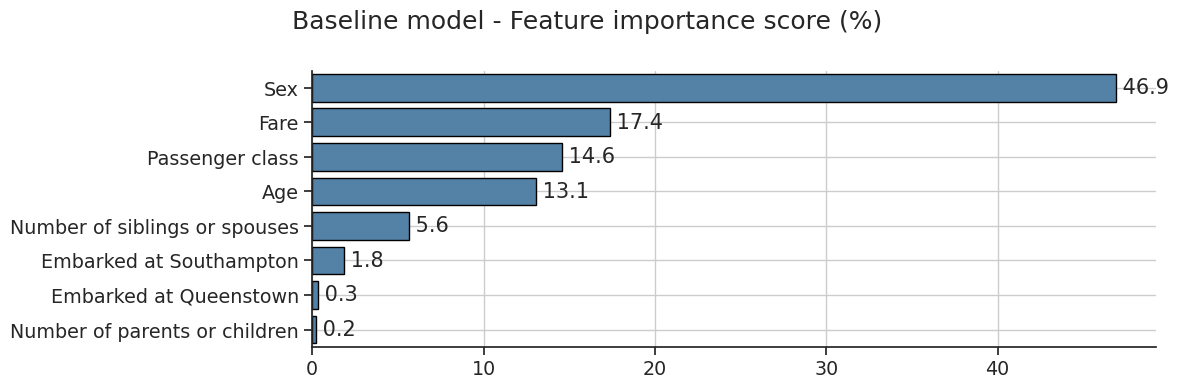

In [16]:
def model_fit(clf, X_train, y_train, title, perform_cv=True, print_feature_importance=True, cv_folds=5):
    "Fits the model of choice, performs CV, creates a model report and plots feature importance"
    
    clf.fit(X_train, y_train) # Fit the algorithm on the data
        
    # Predict training set:
    X_train_predictions = clf.predict(X_train)
    X_train_predprob = clf.predict_proba(X_train)[:,1]
    
    # Print model report:
    print(f"Accuracy on training data: {accuracy_score(train.Survived, gbm_pipeline.predict(train)):.2%}")
    print(f"AUC Score on training data: {roc_auc_score(y_train, X_train_predprob):.2%}")
    
    # Perform cross-validation:
    if perform_cv:        
        cv_score = cross_val_score(clf, X_train, y_train, cv=cv_folds, scoring='accuracy')
        print(f"CV Score - Mean: {np.mean(cv_score):.2%} | " 
              f"Std: {np.std(cv_score):.2%} | "
              f"Min: {np.min(cv_score):.2%} | " 
              f"Max: {np.max(cv_score):.2%}\n"
             )
        
    # Print Feature Importance:
    if print_feature_importance:
        feature_importance_plot(clf, title)        
        
def feature_importance_plot(clf, title):
    "Feature importance bar plot for a given model"
    
    # Create readable labels
    feature_dictionary = {
        'Categorical__Sex_male' : 'Sex',
        'Categorical__Embarked_Q' : 'Embarked at Queenstown',
        'Categorical__Embarked_S' : 'Embarked at Southampton',
        'Numerical__Age' : 'Age',
        'Numerical__SibSp' : 'Number of siblings or spouses',
        'Numerical__Parch' : 'Number of parents or children',
        'Numerical__Fare' : 'Fare',
        'Numerical__Pclass' : 'Passenger class',        
    }
    features_labels = [feature_dictionary[feat] for feat in clf[:-1].get_feature_names_out()]
    
    feat_imp = pd.Series(
        clf._final_estimator.feature_importances_, 
        features_labels
    ).sort_values(ascending=False)

    # Create new figure
    fig, ax = plt.subplots(figsize=(12,4))
    fig.suptitle(title + ' - Feature importance score (%)')

    sns.barplot(
        x = feat_imp.values*100,
        y = feat_imp.index,
        color = 'steelblue',
        edgecolor = 'k',
        orient = 'h',
        errorbar = None,
        ax = ax,
    ).set(
        xlabel = None,
        ylabel = None,
    )
    ax.bar_label(
        ax.containers[-1], 
        fmt=' %.1f', 
        label_type='edge'
    )

    ax.grid()
    fig.tight_layout()
        
model_fit(gbm_pipeline, train, train.Survived, 'Baseline model')

## 3.3 Learning rate and number of estimators <a id="3.3"></a> 
[Previous](#3.2) | [ToC](#ToC) | [Next](#3.4)

First, we initialize some parameters according to the following conventions:
-  Choose a relatively high`learning_rate`. We are using 0.5, corresponding to half the default value;
-  Since this is a imbalanced classification problem, we choose a `min_samples_split` corresponding to 0.5% of total observations;
-  We choose a `max_depth` of 5 due to the low number of observations;
-  Rule-of-thumb to select square root of features as our initial `max_features`;
-  Commonly used `subsample`  value of 0.8.

After the initial definition, we perform a grid search on `n_estimators` ranging from 20 to 100 with steps of 10. The best mean accuracy found was 82.68%, a slight improvement from the baseline model (82.34%). The corresponding parameter value was 70, which is incorporated into the model parameters.

In [17]:
def set_and_get_gbm_params(pipeline, clf, params, display = False):
    "Both set and get a list of parameters in pipeline"
    pipeline[clf].set_params(**params);
    
    if display: # Print a small report for parameters used in classifier
        print('GBM parameters:')
        for param, value in pipeline[clf].get_params().items():
            print(f"- {param}: {value}")
        print('\n')
        
def grid_search(pipeline, param_grid, X_train, y_train):
    "Perform exaustive search on collection of parameters"
    gsearch = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid,
        scoring = 'accuracy',
        n_jobs = -1
    ).fit(X_train, y_train)
    
    # Print small report after gridsearch
    print(f'Grid search best mean accuracy score: {gsearch.best_score_:.2%}')
    print('Corresponding to:')
    for param, value in gsearch.best_params_.items():
        print(f"- {param}: {value}")
    print('\n')
    
    return gsearch

def update_params_dictionary(gsearch, prefix):
    'Remove prefix and update our parameter dictionary'
    for parameter, value in gsearch.best_params_.items():
        gbm_params[parameter[len(prefix):]] = value
        
# gbm_pipeline['gbm'].get_params().keys() # Get the name of all possible parameters

# Initial tree parameters
gbm_params = {
    'learning_rate' : 0.05,
    'min_samples_split' : len(train)//200,
    'max_depth' : 5,
    'max_features' : 'sqrt',
    'subsample' : 0.8,
}
set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)

# Parameters used in current grid search iteration
gsearch_params_1 = {'gbm__n_estimators' : range(20,101,10)}
gsearch_1 = grid_search(gbm_pipeline, gsearch_params_1, train, train.Survived)

# Update our gbm_params dictionary with best parameter found in grid search
update_params_dictionary(gsearch_1, 'gbm__')

gsearch_1 # Display diagram

Grid search best mean accuracy score: 82.68%
Corresponding to:
- gbm__n_estimators: 70




GridSearchCV(estimator=Pipeline(steps=[('Feature encoding',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('Categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Sex',
                                                                          'Embarked']),
                                                                        ('Numerical',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass'])])),
                                       ('gbm',
                                        GradientBoostingClassifier(learning_rate=0.05,
                                                                   max_depth=5,
                                                                   max_features='sqrt',
                                                                   min_samples_split=4,
                                                                   random_state=75,
                                                                   subsample=0.8))]),
             n_jobs=-1, param_grid={'gbm__n_estimators': range(20, 101, 10)},
             scoring='accuracy')

## 3.4 Tree-specific parameters <a id="3.4"></a> 
[Previous](#3.3) | [ToC](#ToC) | [Next](#3.4.1)

When tuning tree-specific parameters, we should tune variables with a higher model impact first. The tuning order will be:
- First, we tune both `max_depth` and `min_samples_split`;
- Then we tune`min_samples_leaf`;
- We tune `max_features` last.

### 3.4.1 Maximum depth and minimum samples <a id="3.4.1"></a> 
[Previous](#3.4) | [ToC](#ToC) | [Next](#3.4.2)

We performed grid search for both features chosing the following intervals:
- `max_depth`: range from 3 to 11 with steps of 2. It was 5 in previous iteration;
- `min_samples_split`: range from 2 to 6 with steps of 1. It was 4 in previous iteration.

We found that mean CV accuracy improves to 82.90% (previously 82.68%) for `max_depth` and `min_samples_split` equal to 7 and 3 respectively.

In [18]:
# Update GBM with best parameters from last iteration
set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)

# Parameters used in current grid search iteration
gsearch_params_2 = {
    'gbm__max_depth' : range(3,12,2), 
    'gbm__min_samples_split' : range(2,7,1)
}
gsearch_2 = grid_search(gbm_pipeline, gsearch_params_2, train, train.Survived)

# Update our gbm_params dictionary with best parameter found in grid search
update_params_dictionary(gsearch_2, 'gbm__')

gsearch_2 # Display diagram

Grid search best mean accuracy score: 82.90%
Corresponding to:
- gbm__max_depth: 7
- gbm__min_samples_split: 3




GridSearchCV(estimator=Pipeline(steps=[('Feature encoding',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('Categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Sex',
                                                                          'Embarked']),
                                                                        ('Numerical',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass'])])),
                                       ('gbm',
                                        GradientBoostingClassifier(learning_rate=0.05,
                                                                   max_depth=5,
                                                                   max_features='sqrt',
                                                                   min_samples_split=4,
                                                                   n_estimators=70,
                                                                   random_state=75,
                                                                   subsample=0.8))]),
             n_jobs=-1,
             param_grid={'gbm__max_depth': range(3, 12, 2),
                         'gbm__min_samples_split': range(2, 7)},
             scoring='accuracy')

### 3.4.2 Minimum samples to be a leaf <a id="3.4.2"></a> 
[Previous](#3.4.1) | [ToC](#ToC) | [Next](#3.4.3)

Testing `min_samples_leaf` values from 1 to 10 we find that 3 corresponds to a slight improvement in mean CV accuracy: from 82.90% to 83.24%.

Before tuning `max_features`, we analyse the impact on feature importance of our tuning process. From comparing the two feature importance plots we can conclude that:
- Feature importances are now more evenly distributed;
- Features `Sex`, `Pclass`, `SibSip` have been given a smaller importance score. All other features have been given a bigger score;
- The previously last ranked feature `Parch` now surpassed `Embarked`;
- `Age` surpassed `Pclass`.

In [19]:
# Update GBM with best parameters from last iteration
set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)

# Parameters used in current grid search iteration
gsearch_params_3 = {'gbm__min_samples_leaf':range(1,11,1)}
gsearch_3 = grid_search(gbm_pipeline, gsearch_params_3, train, train.Survived)

# Update our gbm_params dictionary with best parameter found in grid search
update_params_dictionary(gsearch_3, 'gbm__')

gsearch_3 # Display diagram

Grid search best mean accuracy score: 83.24%
Corresponding to:
- gbm__min_samples_leaf: 3




GridSearchCV(estimator=Pipeline(steps=[('Feature encoding',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('Categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Sex',
                                                                          'Embarked']),
                                                                        ('Numerical',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass'])])),
                                       ('gbm',
                                        GradientBoostingClassifier(learning_rate=0.05,
                                                                   max_depth=7,
                                                                   max_features='sqrt',
                                                                   min_samples_split=3,
                                                                   n_estimators=70,
                                                                   random_state=75,
                                                                   subsample=0.8))]),
             n_jobs=-1, param_grid={'gbm__min_samples_leaf': range(1, 11)},
             scoring='accuracy')

Accuracy on training data: 91.11%
AUC Score on training data: 96.63%
CV Score - Mean: 83.24% | Std: 2.24% | Min: 80.90% | Max: 86.52%



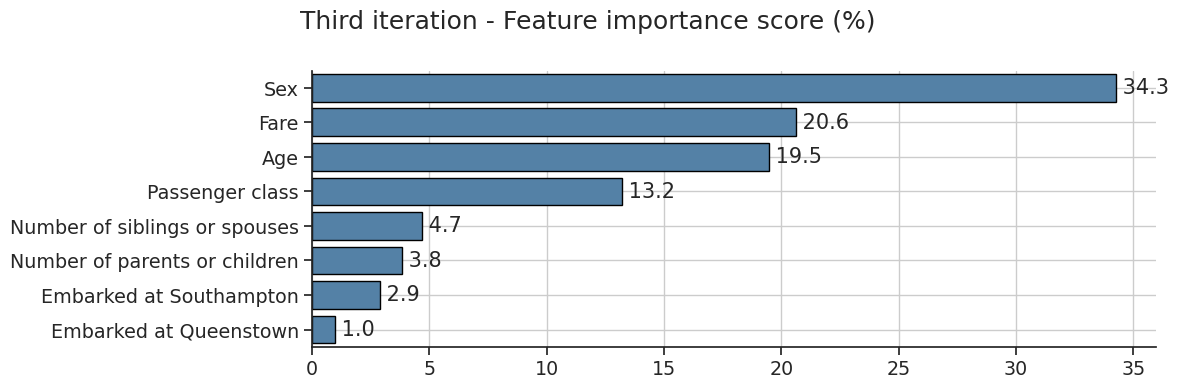

In [20]:
# Update GBM with best parameters from last iteration
set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)

model_fit(gbm_pipeline, train, train.Survived, 'Third iteration')

### 3.4.3 Maximum number of features <a id="3.4.3"></a> 
[Previous](#3.4.2) | [ToC](#ToC) | [Next](#3.5)

Testing `max_features` values from 1 to 8 (corresponding to the maximum number of features) we find that 7 yelds the best mean CV accuracy. From 83.24% to 83.58%.

In [21]:
# Update GBM with best parameters from last iteration
set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)

# Parameters used in current grid search iteration
gsearch_params_4 = {'gbm__max_features' : range(1,gbm_pipeline[:-1].get_feature_names_out().shape[0]+1,1)}
gsearch_4 = grid_search(gbm_pipeline, gsearch_params_4, train, train.Survived)

# Update our gbm_params dictionary with best parameter found in grid search
update_params_dictionary(gsearch_4, 'gbm__')

gsearch_4 # Display diagram

Grid search best mean accuracy score: 83.58%
Corresponding to:
- gbm__max_features: 7




GridSearchCV(estimator=Pipeline(steps=[('Feature encoding',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('Categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Sex',
                                                                          'Embarked']),
                                                                        ('Numerical',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass'])])),
                                       ('gbm',
                                        GradientBoostingClassifier(learning_rate=0.05,
                                                                   max_depth=7,
                                                                   max_features='sqrt',
                                                                   min_samples_leaf=3,
                                                                   min_samples_split=3,
                                                                   n_estimators=70,
                                                                   random_state=75,
                                                                   subsample=0.8))]),
             n_jobs=-1, param_grid={'gbm__max_features': range(1, 9)},
             scoring='accuracy')

## 3.5 Subsample <a id="3.5"></a> 
[Previous](#3.4.3) | [ToC](#ToC) | [Next](#3.6)

Initialy `subsample` was set to 0.8 and its corresponding accuracy was 83.58%. Testing values ranging from 0.3 to 1 with steps of 0.05, the value of 0.5 yields the best CV accuracy score of 84.59%.

In [22]:
# Update GBM with best parameters from last iteration
set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)

# Parameters used in current grid search iteration
gsearch_params_5 = {'gbm__subsample' : np.arange(0.3, 1.05, 0.05)}
gsearch_5 = grid_search(gbm_pipeline, gsearch_params_5, train, train.Survived)

# Update our gbm_params dictionary with best parameter found in grid search
update_params_dictionary(gsearch_5, 'gbm__')

gsearch_5 # Display diagram

Grid search best mean accuracy score: 84.59%
Corresponding to:
- gbm__subsample: 0.49999999999999994




GridSearchCV(estimator=Pipeline(steps=[('Feature encoding',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('Categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Sex',
                                                                          'Embarked']),
                                                                        ('Numerical',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass'])])),
                                       ('gbm',
                                        GradientBoostingClassifier(learning_rate=0.05,
                                                                   max_depth=7,
                                                                   max_features=7,
                                                                   min_samples_leaf=3,
                                                                   min_samples_split=3,
                                                                   n_estimators=70,
                                                                   random_state=75,
                                                                   subsample=0.8))]),
             n_jobs=-1,
             param_grid={'gbm__subsample': array([0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ,
       0.85, 0.9 , 0.95, 1.  ])},
             scoring='accuracy')

## 3.6 Revisiting learning rate and number of estimators <a id="3.6"></a> 
[Previous](#3.5) | [ToC](#ToC) | [Next](#3.7)

Now that we found the optimal tree parameters, let's revisit `learning_rate` and `n_estimators`. Their initial values were 0.05 and 70, respectively. These attributes are must be tuned in a inversely proportional fashion. I.e. if we chose to double one we must halve the other:
- `n_estimators`: ranging from 280 to 17, halving each step;
- `learning_rate`: ranging from 0.0125 to 0.2, doubling each step.

We find that the original values 0.05 and 70 for `learning_rate` and `n_estimators` were the optimal yielding the highest average CV score of 84.59%.

In [23]:
for i in range(-2,3):
    # Multiply and divide learning rate and n_estimators according to i
    lr, ne = 0.05*2**i, int(70*2**(-1*i)) 
    print(f'[learning_rate: {lr} n_estimators:{ne}]')
    
    # Update GBM parameters
    gbm_params['learning_rate'], gbm_params['n_estimators'] = lr, ne
    set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)
    
    # Fit model for each combination
    model_fit(gbm_pipeline, train, train.Survived, 'Fifth iteration', print_feature_importance=False)
    
# Set parameters to their optimal value:
gbm_params['learning_rate'], gbm_params['n_estimators'] = 0.05, 70
set_and_get_gbm_params(gbm_pipeline, 'gbm', gbm_params)

[learning_rate: 0.0125 n_estimators:280]
Accuracy on training data: 91.23%
AUC Score on training data: 97.75%
CV Score - Mean: 83.92% | Std: 1.95% | Min: 81.46% | Max: 86.44%

[learning_rate: 0.025 n_estimators:140]
Accuracy on training data: 91.90%
AUC Score on training data: 97.69%
CV Score - Mean: 84.25% | Std: 2.15% | Min: 82.02% | Max: 87.64%

[learning_rate: 0.05 n_estimators:70]
Accuracy on training data: 91.11%
AUC Score on training data: 97.55%
CV Score - Mean: 84.59% | Std: 1.88% | Min: 82.58% | Max: 87.01%

[learning_rate: 0.1 n_estimators:35]
Accuracy on training data: 91.79%
AUC Score on training data: 97.69%
CV Score - Mean: 83.69% | Std: 2.15% | Min: 80.34% | Max: 86.52%

[learning_rate: 0.2 n_estimators:17]
Accuracy on training data: 90.55%
AUC Score on training data: 97.14%
CV Score - Mean: 82.34% | Std: 1.28% | Min: 80.34% | Max: 84.18%



## 3.7 Predictions <a id="3.7"></a> 
[Previous](#3.6) | [ToC](#ToC) | [Next](#4)

After retraining the classifier using the optimal values, we finally generate the _'submission.csv'_ containing the survival predictions for the `test` set.

In [24]:
# Fit model using optimal parameters
model_fit(gbm_pipeline, train, train.Survived, 'Last Iteration', print_feature_importance=False);

# Make predictions
test_predictions = gbm_pipeline.predict(test)

# Save submission on desired format
output = pd.DataFrame({'PassengerId': test.index,
                       'Survived': test_predictions})
output.to_csv('submission.csv', index=False)

Accuracy on training data: 91.11%
AUC Score on training data: 97.55%
CV Score - Mean: 84.59% | Std: 1.88% | Min: 82.58% | Max: 87.01%



# 4. Conclusion <a id="4"></a>
[Previous](#3) | [ToC](#ToC) | [Next](#4)

In this competition we had the oportunity to explore a bunch of analysis and machine learning processes on a small dataset.

For future implementations, in order to improve the accuracy score, one might try and combine some features. For example combining `SibSp` and `Parch` we could generate a new binary feature `alone` that checks if a passenger was not accompanied during the trip, as it seems to be a significant part of training data.

We could also create new features. For example a binary feature that checks the presence of `Cabin` on passenger registration. Another interesting feature would be to infer from their name if a passenger was a member of the crew.